In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('00007.csv')

In [3]:
df


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.199923,-0.003475,6.145254,0.0004,0.000,0.000
1,4.199354,-0.000950,6.158222,0.0002,4.215,9.328
2,4.021734,-0.996832,6.205069,1.0000,3.435,23.313
3,4.002574,-0.996958,6.262182,1.0000,3.430,36.500
4,3.987979,-0.994090,6.290079,1.0000,3.417,49.672
...,...,...,...,...,...,...
419,2.514751,-0.993004,10.640508,1.0000,1.950,5536.688
420,2.470710,-0.995242,10.557208,1.0000,1.907,5550.110
421,2.974855,-0.005276,10.550361,0.0004,0.000,5563.703
422,3.078816,-0.003130,10.323602,0.0004,0.000,5577.282


In [4]:
df.head()


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.199923,-0.003475,6.145254,0.0004,0.000,0.000
1,4.199354,-0.000950,6.158222,0.0002,4.215,9.328
2,4.021734,-0.996832,6.205069,1.0000,3.435,23.313
3,4.002574,-0.996958,6.262182,1.0000,3.430,36.500
4,3.987979,-0.994090,6.290079,1.0000,3.417,49.672


       Voltage_measured  Current_measured  Temperature_measured  Current_load  \
count        424.000000        424.000000            424.000000    424.000000   
mean           3.470767         -0.983889              7.954455      0.988211   
std            0.278535          0.107315              1.416882      0.108044   
min            2.470710         -1.000307              4.922178      0.000200   
25%            3.350911         -0.996263              7.038276      1.000000   
50%            3.506248         -0.995584              7.843193      1.000000   
75%            3.658188         -0.994859              8.673799      1.000000   
max            4.199923         -0.000746             11.624528      1.000000   

       Voltage_load         Time  
count    424.000000   424.000000  
mean       2.884255  2786.419943  
std        0.400146  1618.570231  
min        0.000000     0.000000  
25%        2.780000  1390.606000  
50%        2.940000  2782.750500  
75%        3.104500  4180

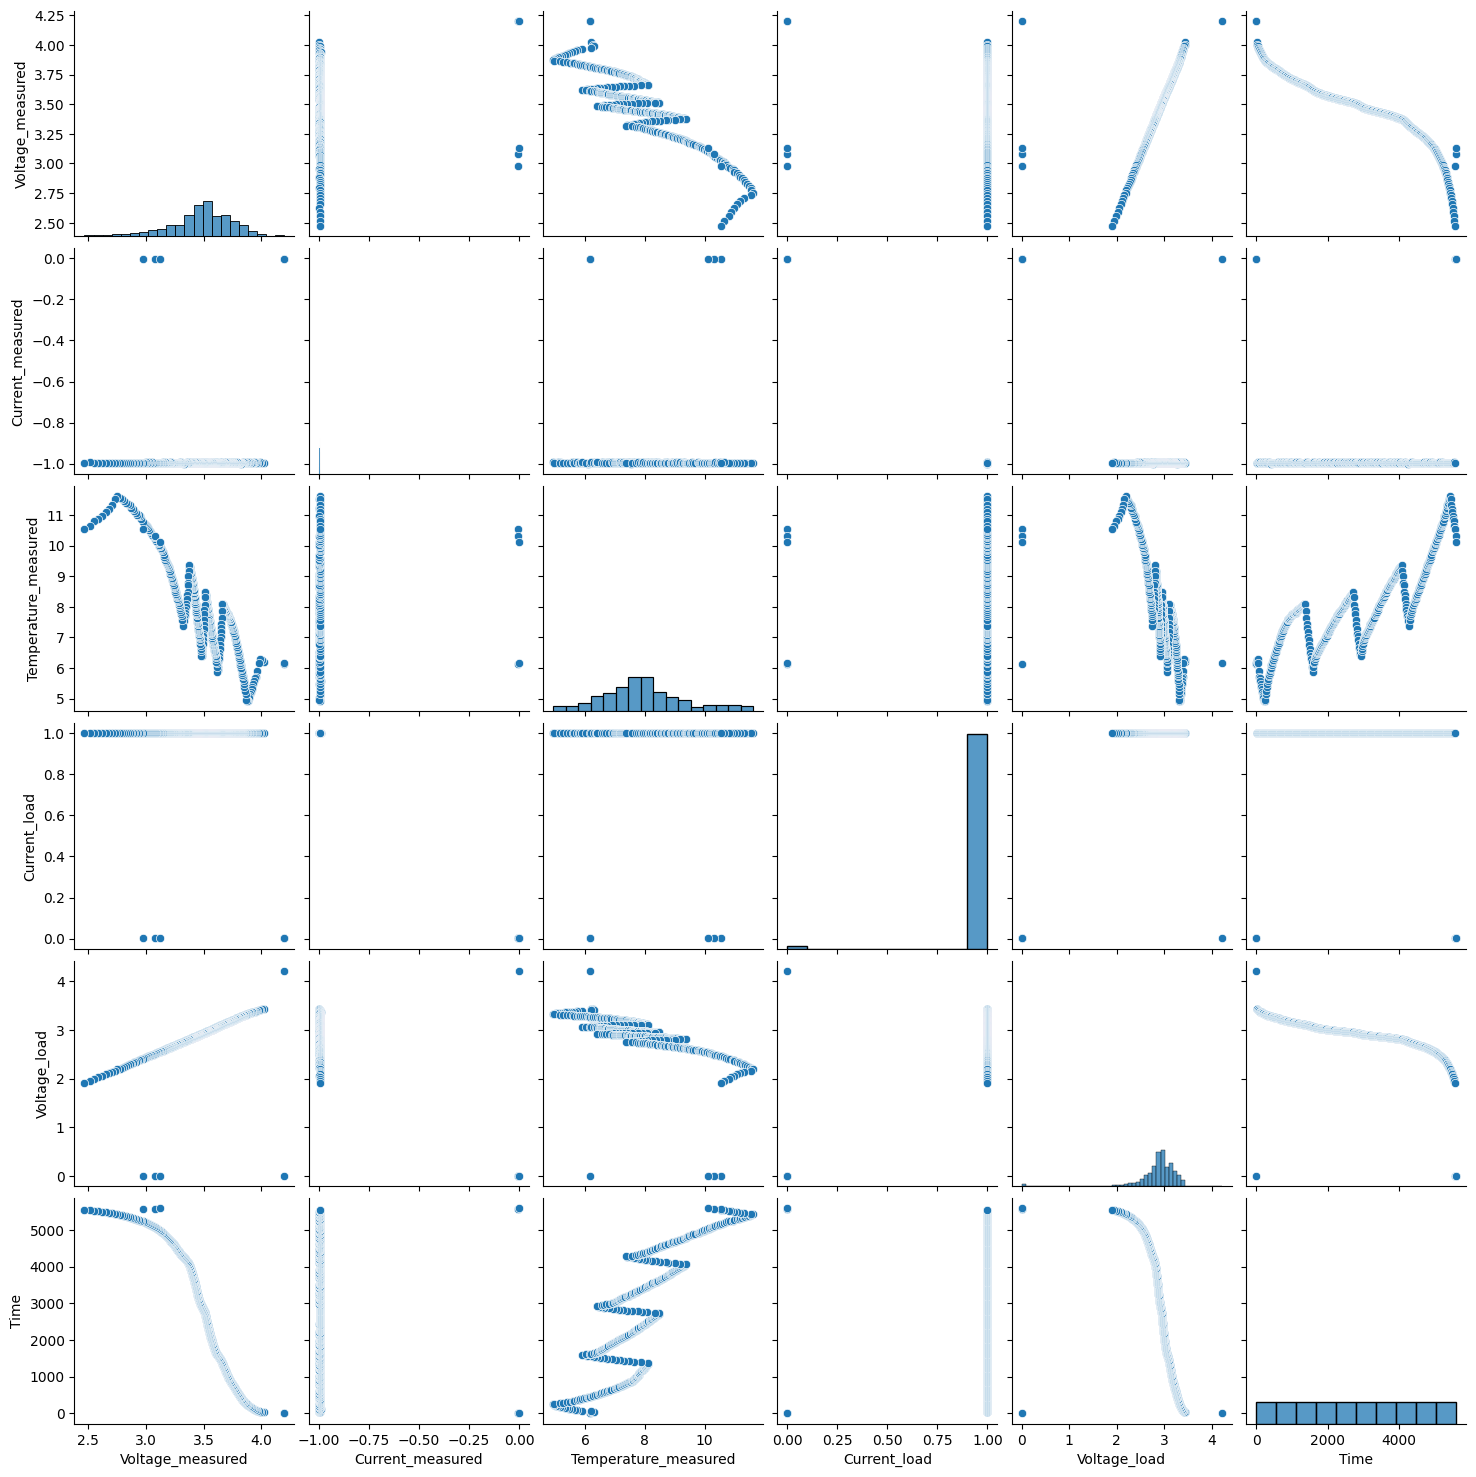

In [5]:
print(df.describe())
sns.pairplot(df)
plt.show()

In [6]:


df['dV'] = df['Voltage_measured'].diff()
df['dQ'] = df['Current_measured'].diff()
df['dQ/dV'] = df['dQ'] / df['dV']

In [8]:
df.dropna(inplace=True)

In [9]:
window_size = 5
df['Voltage_measured_avg'] = df['Voltage_measured'].rolling(window=window_size).mean()
df['Current_measured_avg'] = df['Current_measured'].rolling(window=window_size).mean()
df['Temperature_measured_avg'] = df['Temperature_measured'].rolling(window=window_size).mean()
df.dropna(inplace=True)

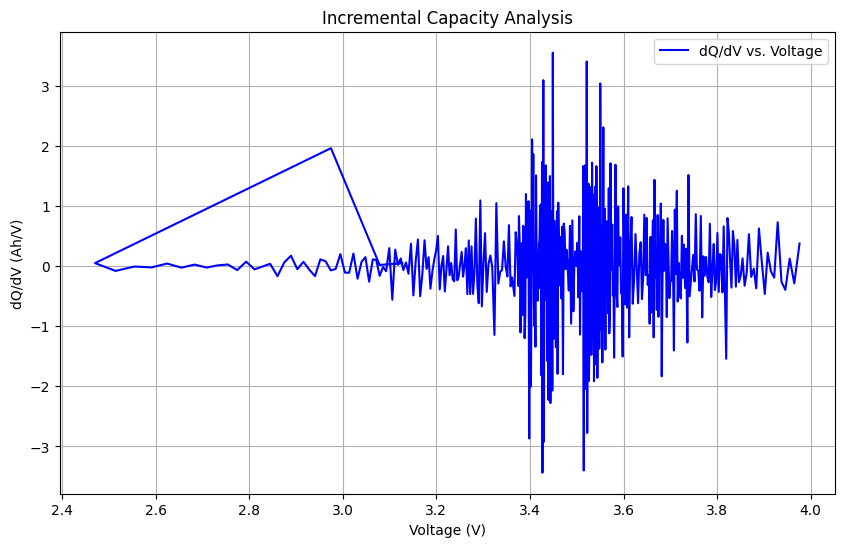

In [10]:
plt.figure(figsize=(10,6))
plt.plot(df['Voltage_measured'], df['dQ/dV'], label='dQ/dV vs. Voltage', color='b')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV (Ah/V)')
plt.title('Incremental Capacity Analysis')
plt.legend()
plt.grid()
plt.show()

In [11]:
from mpl_toolkits.mplot3d import Axes3D

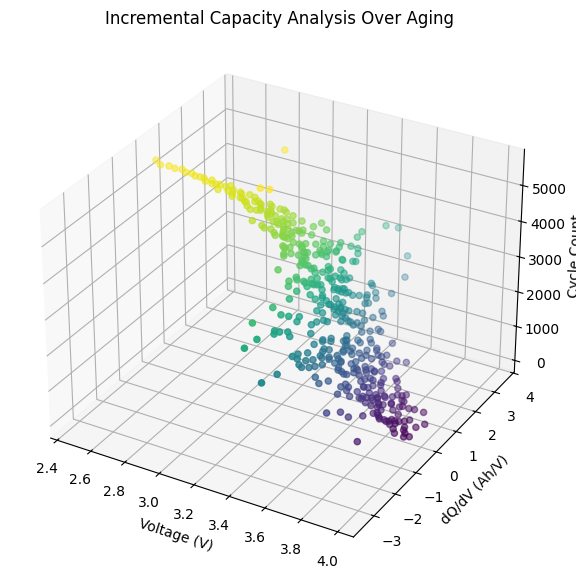

In [12]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Voltage_measured'], df['dQ/dV'], df['Time'], c=df['Time'], cmap='viridis')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('dQ/dV (Ah/V)')
ax.set_zlabel('Cycle Count')
ax.set_title('Incremental Capacity Analysis Over Aging')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
features = df[['Voltage_measured', 'Current_measured', 'Temperature_measured',
               'Voltage_measured_avg', 'Current_measured_avg', 'Temperature_measured_avg']]
labels = df['Voltage_load']  # Placeholder for actual capacity or EIS signature
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [17]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

In [19]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Model Mean Absolute Error: {mae}')
print(f'Model R^2 Score: {r2}')
print(f'Best Model Parameters: {grid_search.best_params_}')

Model Mean Absolute Error: 0.012078119047618926
Model R^2 Score: 0.9628337510787408
Best Model Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
